# Case Study 6 : Data Science in Any Data You Like

**Required Readings:** 
* In this case study, you could use any data as you like.
* [TED Talks](https://www.ted.com/talks) for examples of 10 minutes talks.


** NOTE **
* Please don't forget to save the notebook frequently when working in Jupyter Notebook, otherwise the changes you made can be lost.

*----------------------

# Problem: pick a data science problem that you plan to solve using your Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using the data and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

# Data Collection/Processing: 

In [2]:
import os, sys, csv, datetime, json
import cPickle as pickle
import numpy as np

from IPython.display import clear_output

data_dir = 'data'

# General statistics
boros_accs = dict()
time_day_accs = dict()

# Our problem statistics
cause_accs = dict()
vehicle_type_accs = dict()

# Get each data file path
data_files = [os.path.abspath(os.path.join(data_dir, file)) for file in os.listdir(data_dir)]

i = 0

def add_count_to_dict(dictionary, key):
    if not dictionary.has_key(key):
        dictionary[key] = 1
    else:
        dictionary[key] += 1

# Read each file
for data_file in data_files:
    with open(data_file, 'r') as f:
        reader = csv.reader(f)
        headers = next(reader) # Skip header

        # Read each record
        for row in reader:
            add_count_to_dict(boros_accs, row[2])
            add_count_to_dict(time_day_accs, int(row[1].split(':')[0]))
            
            # Vehicle types
            add_count_to_dict(vehicle_type_accs, row[24])
            add_count_to_dict(vehicle_type_accs, row[25])
            add_count_to_dict(vehicle_type_accs, row[26])
            add_count_to_dict(vehicle_type_accs, row[27])
            add_count_to_dict(vehicle_type_accs, row[28])
            
            # Accident causes
            add_count_to_dict(cause_accs, row[18])
            add_count_to_dict(cause_accs, row[19])
            add_count_to_dict(cause_accs, row[20])
            add_count_to_dict(cause_accs, row[21])
            add_count_to_dict(cause_accs, row[22])
            
            # Progress output
            if i % 1000 == 0:
                clear_output()
                print 'Processed {} records.'.format(i)
            i += 1
        
        clear_output()
        print 'Finished processing.'

Finished processing.


# Data Exploration: Exploring the your data

** plot some properties/statistics/distribution of your data** 

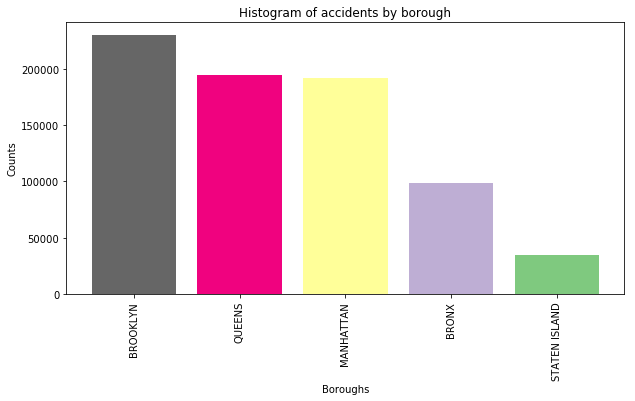

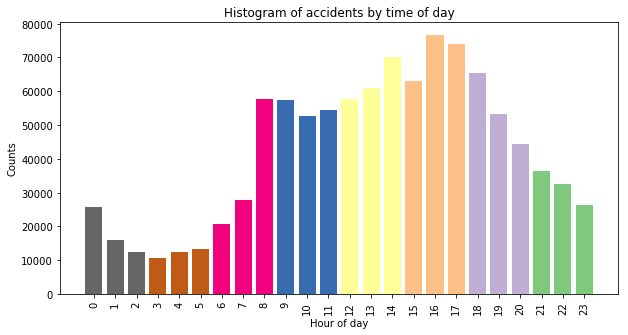

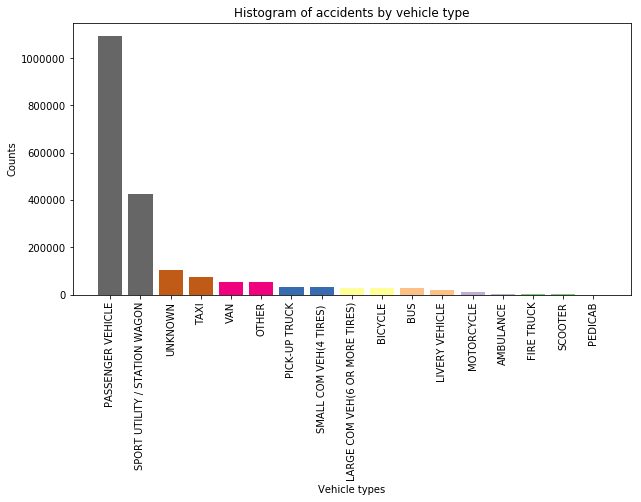

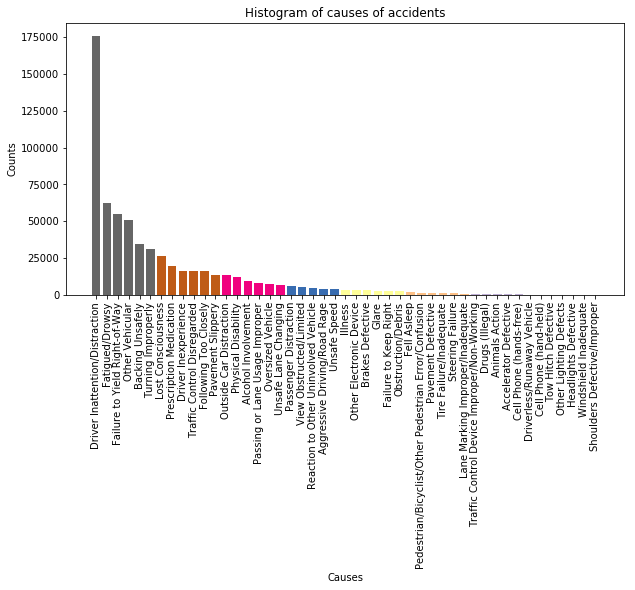

In [ ]:
import matplotlib.pyplot as plt

# Remove empty data
boros_accs.pop('', None)
time_day_accs.pop('', None)
cause_accs.pop('', None)
cause_accs.pop('Unspecified', None)
vehicle_type_accs.pop('', None)

def make_hist_chart(dictionary, title, x_axis, y_axis, sort_keys=True):
    plt.figure(figsize=(10, 5))

    # Get months and averages
    categories = None
    counts = None
    
    if sort_keys:
        sorted_cats = sorted(dictionary, key=dictionary.get, reverse=True)
        categories = [category for category in sorted_cats]
        counts = [dictionary[category] for category in sorted_cats]
    else:
        categories = [category for category in dictionary.keys()]
        counts = [dictionary[category] for category in dictionary.keys()]

    # Get colors
    cmap = plt.get_cmap('Accent_r')
    colors = [cmap(i) for i in np.linspace(0, 1, len(categories))]
    cat_len = range(len(categories))

    # Bar chart
    plt.bar(cat_len, counts, align='center', color=colors)
    
    # Labels
    locs, labels = plt.xticks(cat_len, categories)
    plt.setp(labels, rotation=90)
    plt.title(title)
    plt.tick_params(axis='x', which='both', top='off')
    plt.tick_params(axis='y', which='both', right='off')
    
    # Axes
    ax = plt.gca()
    ax.tick_params(direction='out')
    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    
    plt.show()

make_hist_chart(boros_accs, 'Histogram of accidents by borough', 'Boroughs', 'Counts')
make_hist_chart(time_day_accs, 'Histogram of accidents by time of day', 'Hour of day', 'Counts', sort_keys=False)
make_hist_chart(vehicle_type_accs, 'Histogram of accidents by vehicle type', 'Vehicle types', 'Counts')
make_hist_chart(cause_accs, 'Histogram of causes of accidents', 'Causes', 'Counts')

# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

Write codes to implement the solution in python:

In [ ]:
import csv

with open('data/NYPD_Motor_Vehicle_Collisions.csv') as infile:
    reader = csv.DictReader(infile)
    injured = []
    fatality = []
    bicycle = []
    pedestrian = []
    taxi = []
    emergency = []
    distract = []
    infr_fail = []
    for line in reader:
        if line['NUMBER OF PERSONS INJURED'] != '0':
            injured.append(line)
        if line['NUMBER OF PERSONS KILLED'] != '0':
            fatality.append(line)
        if line['NUMBER OF PEDESTRIANS INJURED'] != '0' or line['NUMBER OF PEDESTRIANS KILLED'] != '0':
            pedestrian.append(line)
        for i in range(1,6):
            if line[('VEHICLE TYPE CODE ' + str(i))] == 'BICYCLE':
                bicycle.append(line)
            if line[('VEHICLE TYPE CODE ' + str(i))] == 'TAXI':
                taxi.append(line)
            if line[('VEHICLE TYPE CODE ' + str(i))] in ['AMBULANCE' or 'FIRE TRUCK']:
                emergency.append(line)
            if line[('CONTRIBUTING FACTOR VEHICLE ' + str(i))] == 'Driver Inattention/Distraction':
                distract.append(line)
            if line[('CONTRIBUTING FACTOR VEHICLE ' + str(i))] in ['Shoulders Defective/Improper', 'Traffic Control Device Improper/Nonworking', 
                                                                   'Lane Marking Improper/Inadequate', 'Pavement Defective', 'Obstruction/Debris',
                                                                   'View Obstructed/Limited', 'Oversized Vehicle', 'Pavement Slippery']:
                infr_fail.append(line)
            
for i in [injured, fatality, bicycle, pedestrian, taxi, emergency, distract, infr_fail]:
    print (i, ':', len(i))

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

# Read from csv file, make latitude and longitude lists
with open('data/NYPD_Motor_Vehicle_Collisions.csv') as infile:
    reader = csv.DictReader(infile)
    lat = []
    lon = []
    i = 0
    for line in reader:
        if line['LATITUDE'] == '' or line['LONGITUDE'] == '':
            continue
        else: 
            lat.append(float(line['LATITUDE']))
            lon.append(float(line['LONGITUDE']))
            i += 1 
            if i >= 100: # 
                break

# Set up map
fig, ax = plt.subplots(figsize=(18,18))      
map = Basemap(projection='mill',
            llcrnrlat = 40.5,
            llcrnrlon = -74.1,
            urcrnrlat = 40.9,
            urcrnrlon = -73.7,
            resolution='c')

map.drawmapboundary(fill_color = 'snow')
map.readshapefile('nyc_shapefile/nyc', 'nyc')

# Separate water and land polygons in shapefile
water_patches = []
land_patches = []
water_tiles = [13936, 7906, 3830, 1456, 1311, 581, 291, 120, 107, 19]

# Color shapefile polygons
for info, shape in zip(map.nyc_info, map.nyc):
    if len(shape) in water_tiles:
        water_patches.append(Polygon(np.array(shape), True))
    else: 
        land_patches.append(Polygon(np.array(shape), True))
ax.add_collection(PatchCollection(water_patches, facecolor= 'navy', edgecolor='k', linewidths=0.3, zorder=2))
ax.add_collection(PatchCollection(land_patches, facecolor= 'snow', edgecolor='k', linewidths=0.3, zorder=2))

# Add datapoints
x,y = map(lon, lat)
map.scatter(x,y, marker = '.', color = 'blueviolet', )

# Show Plots
plt.show()

# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.


In [ ]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary








*-----------------
# Done

All set! 

** What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "jupyter notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.

* **PPT Slides**: please prepare PPT slides (for 10 minutes' talk) to present about the case study . Each team present their case studies in class for 10 minutes.

Please compress all the files in a zipped file.


** How to submit: **

        Please submit through Canvas, in the Assignment "Case Study 6".
        
** Note: Each team only needs to submit one submission in Canvas **


# Peer-Review Grading Template:

** Total Points: (100 points) ** Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.

Please add an "**X**" mark in front of your rating: 

For example:

*2: bad*
          
**X** *3: good*
    
*4: perfect*


    ---------------------------------
    The Problem: 
    ---------------------------------
    
    1. (10 points) how well did the team describe the problem they are trying to solve using the data? 
       0: not clear
       2: I can barely understand the problem
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
    
    2. (10 points) do you think the problem is important or has a potential impact?
        0: not important at all
        2: not sure if it is important
        4: seems important, but not clear
        6: interesting problem
        8: an important problem, which I want to know the answer myself
       10: very important, I would be happy invest money on a project like this.
    
    ----------------------------------
    Data Collection and Processing:
    ----------------------------------
    
    3. (10 points) Do you think the data collected/processed are relevant and sufficient for solving the above problem? 
       0: not clear
       2: I can barely understand what data they are trying to collect/process
       4: I can barely understand why the data is relevant to the problem
       6: the data are relevant to the problem, but better data can be collected
       8: the data collected are relevant and at a proper scale
      10: the data are properly collected and they are sufficient

    -----------------------------------
    Data Exploration:
    -----------------------------------
    4. How well did the team solve the following task:
    
    (1) plot some properties/statistics/distribution of your data (10 points):
       0: missing answer
       4: okay, but with major problems
       7: good, but with minor problems
      10: perfect
    

    -----------------------------------
    The Solution
    -----------------------------------
    5.  how well did the team describe the solution they used to solve the problem? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
       
    6. how well is the solution in solving the problem? (10 points)
       0: not relevant
       2: barely relevant to the problem
       4: okay solution, but there is an easier solution.
       6: good, but can be improved
       8: very good, but solution is simple/old
       10: innovative and technically sound
       
    7. how well did the team implement the solution in python? (10 points)
       0: the code is not relevant to the solution proposed
       2: the code is barely understandable, but not relevant
       4: okay, the code is clear but incorrect
       6: good, the code is correct, but with major errors
       8: very good, the code is correct, but with minor errors
      10: perfect 
   
    -----------------------------------
    The Results
    -----------------------------------
     8.  How well did the team present the results they found in the data? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
      10: crystal clear
       
     9.  How do you think of the results they found in the data?  (5 points)
       0: not clear
       1: likely to be wrong
       2: okay, maybe wrong
       3: good, but can be improved
       4: make sense, but not interesting
       5: make sense and very interesting
     
    -----------------------------------
    The Presentation
    -----------------------------------
    10. How all the different parts (data, problem, solution, result) fit together as a coherent story?  
       0: they are irrelevant
       1: I can barely understand how they are related to each other
       2: okay, the problem is good, but the solution doesn't match well, or the problem is not solvable.
       3: good, but the results don't make much sense in the context
       4: very good fit, but not exciting (the storyline can be improved/polished)
       5: a perfect story
      
    11. Did the presenter make good use of the 10 minutes for presentation?  
       0: the team didn't present
       1: bad, barely finished a small part of the talk
       2: okay, barely finished most parts of the talk.
       3: good, finished all parts of the talk, but some part is rushed
       4: very good, but the allocation of time on different parts can be improved.
       5: perfect timing and good use of time      

    12. How well do you think of the presentation (overall quality)?  
       0: the team didn't present
       1: bad
       2: okay
       3: good
       4: very good
       5: perfect


    -----------------------------------
    Overall: 
    -----------------------------------
    13. How many points out of the 100 do you give to this project in total?  Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.
    Total score:
    
    14. What are the strengths of this project? Briefly, list up to 3 strengths.
       1: 
       2:
       3:
    
    15. What are the weaknesses of this project? Briefly, list up to 3 weaknesses.
       1:
       2:
       3:
    
    16. Detailed comments and suggestions. What suggestions do you have for this project to improve its quality further.
    
    
    

    ---------------------------------
    Your Vote: 
    ---------------------------------
    1. [Overall Quality] Between the two submissions that you are reviewing, which team would you vote for a better score?  (5 bonus points)
        0: I vote the other team is better than this team
        5: I vote this team is better than the other team 
        
    2. [Presentation] Among all the teams in the presentation, which team do you think deserves the best presentation award for this case study?  
        1: Team 1
        2: Team 2
        3: Team 3
        4: Team 4
        5: Team 5
        6: Team 6
        7: Team 7
        8: Team 8
        9: Team 9


